# Method 5 - Rest Ideas After 5

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns per Shumway, Szefler, Yuan 2009

%store -r exp_ret

valid_data = valid_data.merge(exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Rest Ideas

In [3]:
# Extract Rest Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] > 5].copy()

# Weight the best ideas

best_ideas['target'] = best_ideas['target'] / best_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / best_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

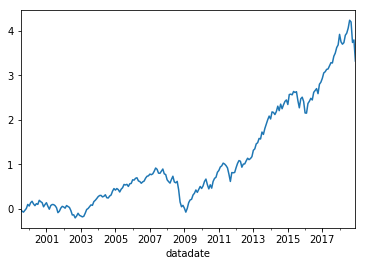

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.102551
2000-12-31   -0.002465
2001-12-31   -0.036841
2002-12-31   -0.190933
2003-12-31    0.440057
2004-12-31    0.181248
2005-12-31    0.079345
2006-12-31    0.108305
2007-12-31    0.016511
2008-12-31   -0.389697
2009-12-31    0.391768
2010-12-31    0.211356
2011-12-31   -0.002768
2012-12-31    0.194628
2013-12-31    0.419037
2014-12-31    0.117226
2015-12-31   -0.010318
2016-12-31    0.127301
2017-12-31    0.217431
2018-12-31   -0.077288
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     2624.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          6.07e-190
Time:                        05:44:45   Log-Likelihood:                 839.86
No. Observations:                 234   AIC:                            -1670.
Df Residuals:                     229   BIC:                            -1652.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      4.820      0.000       0.001       0.003
mktrf          0.9858      0.013     78.235      0.000       0.961       1.011
me             0.2453      0.015     16.735      0.000       0.216       0.274
ia             0.0780      0.022      3.502      0.001       0.034       0.122
roe            0.0160      0.019      0.841      0.401      -0.022       0.054
==============================================================================
Omnibus:                       17.361   Durbin-Watson:                   1.737
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.134
Skew:                          -0.121   Prob(JB):                     2.90e-12
Kurtosis:                       5.322   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     1586.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.29e-165
Time:                        05:44:45   Log-Likelihood:                 839.86
No. Observations:                 234   AIC:                            -1670.
Df Residuals:                     229   BIC:                            -1652.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      4.670      0.000       0.001       0.003
mktrf          0.9858      0.017     59.327      0.000       0.953       1.018
me             0.2453      0.030      8.068      0.000       0.186       0.305
ia             0.0780      0.045      1.728      0.084      -0.010       0.166
roe            0.0160      0.023      0.689      0.491      -0.030       0.062
==============================================================================
Omnibus:                       17.361   Durbin-Watson:                   1.737
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.134
Skew:                          -0.121   Prob(JB):                     2.90e-12
Kurtosis:                       5.322   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     2090.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          6.71e-179
Time:                        05:44:45   Log-Likelihood:                 839.86
No. Observations:                 234   AIC:                            -1670.
Df Residuals:                     229   BIC:                            -1652.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      4.988      0.000       0.001       0.003
mktrf          0.9858      0.016     62.951      0.000       0.955       1.017
me             0.2453      0.029      8.495      0.000       0.189       0.302
ia             0.0780      0.050      1.559      0.119      -0.020       0.176
roe            0.0160      0.026      0.627      0.531      -0.034       0.066
==============================================================================
Omnibus:                       17.361   Durbin-Watson:                   1.737
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.134
Skew:                          -0.121   Prob(JB):                     2.90e-12
Kurtosis:                       5.322   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1862.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.23e-182
Time:                        05:44:45   Log-Likelihood:                 826.69
No. Observations:                 234   AIC:                            -1641.
Df Residuals:                     228   BIC:                            -1621.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.000      3.845      0.000       0.001       0.003
mktrf          0.9974      0.013     74.507      0.000       0.971       1.024
smb            0.2780      0.018     15.739      0.000       0.243       0.313
hml            0.0155      0.021      0.742      0.459      -0.026       0.056
rmw            0.0496      0.024      2.108      0.036       0.003       0.096
cma            0.0552      0.030      1.843      0.067      -0.004       0.114
==============================================================================
Omnibus:                       22.736   Durbin-Watson:                   1.606
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               97.172
Skew:                          -0.040   Prob(JB):                     7.93e-22
Kurtosis:                       6.156   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1145.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.63e-159
Time:                        05:44:45   Log-Likelihood:                 826.69
No. Observations:                 234   AIC:                            -1641.
Df Residuals:                     228   BIC:                            -1621.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.572      0.000       0.001       0.003
mktrf          0.9974      0.020     49.929      0.000       0.958       1.037
smb            0.2780      0.025     10.948      0.000       0.228       0.328
hml            0.0155      0.048      0.321      0.749      -0.079       0.110
rmw            0.0496      0.027      1.850      0.064      -0.003       0.102
cma            0.0552      0.048      1.150      0.250      -0.039       0.149
==============================================================================
Omnibus:                       22.736   Durbin-Watson:                   1.606
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               97.172
Skew:                          -0.040   Prob(JB):                     7.93e-22
Kurtosis:                       6.156   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1561.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.88e-174
Time:                        05:44:45   Log-Likelihood:                 826.69
No. Observations:                 234   AIC:                            -1641.
Df Residuals:                     228   BIC:                            -1621.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.595      0.000       0.001       0.003
mktrf          0.9974      0.020     51.146      0.000       0.959       1.036
smb            0.2780      0.025     11.040      0.000       0.229       0.327
hml            0.0155      0.053      0.294      0.769      -0.088       0.119
rmw            0.0496      0.030      1.670      0.095      -0.009       0.108
cma            0.0552      0.046      1.200      0.230      -0.035       0.145
==============================================================================
Omnibus:                       22.736   Durbin-Watson:                   1.606
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               97.172
Skew:                          -0.040   Prob(JB):                     7.93e-22
Kurtosis:                       6.156   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     2041.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          9.25e-178
Time:                        05:44:45   Log-Likelihood:                 811.19
No. Observations:                 234   AIC:                            -1612.
Df Residuals:                     229   BIC:                            -1595.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      4.606      0.000       0.001       0.003
mktrf          0.9811      0.013     74.812      0.000       0.955       1.007
smb            0.2425      0.016     14.816      0.000       0.210       0.275
hml            0.1049      0.016      6.453      0.000       0.073       0.137
umd            0.0027      0.011      0.256      0.798      -0.018       0.024
==============================================================================
Omnibus:                       24.279   Durbin-Watson:                   1.633
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.604
Skew:                           0.021   Prob(JB):                     3.53e-25
Kurtosis:                       6.398   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     1546.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.12e-164
Time:                        05:44:45   Log-Likelihood:                 811.19
No. Observations:                 234   AIC:                            -1612.
Df Residuals:                     229   BIC:                            -1595.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      3.798      0.000       0.001       0.004
mktrf          0.9811      0.019     51.989      0.000       0.944       1.018
smb            0.2425      0.030      8.185      0.000       0.184       0.301
hml            0.1049      0.051      2.066      0.039       0.005       0.204
umd            0.0027      0.018      0.153      0.878      -0.032       0.038
==============================================================================
Omnibus:                       24.279   Durbin-Watson:                   1.633
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.604
Skew:                           0.021   Prob(JB):                     3.53e-25
Kurtosis:                       6.398   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     2039.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.03e-177
Time:                        05:44:45   Log-Likelihood:                 811.19
No. Observations:                 234   AIC:                            -1612.
Df Residuals:                     229   BIC:                            -1595.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      3.809      0.000       0.001       0.004
mktrf          0.9811      0.017     58.466      0.000       0.948       1.014
smb            0.2425      0.031      7.755      0.000       0.181       0.304
hml            0.1049      0.058      1.799      0.072      -0.009       0.219
umd            0.0027      0.014      0.198      0.843      -0.024       0.030
==============================================================================
Omnibus:                       24.279   Durbin-Watson:                   1.633
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.604
Skew:                           0.021   Prob(JB):                     3.53e-25
Kurtosis:                       6.398   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     1182.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.28e-92
Time:                        05:44:45   Log-Likelihood:                 412.95
No. Observations:                 120   AIC:                            -815.9
Df Residuals:                     115   BIC:                            -802.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      3.429      0.001       0.001       0.004
mktrf          0.9976      0.020     48.894      0.000       0.957       1.038
me             0.2302      0.020     11.423      0.000       0.190       0.270
ia             0.1248      0.032      3.954      0.000       0.062       0.187
roe            0.0224      0.028      0.803      0.424      -0.033       0.078
==============================================================================
Omnibus:                        6.781   Durbin-Watson:                   1.727
Prob(Omnibus):                  0.034   Jarque-Bera (JB):               11.643
Skew:                          -0.084   Prob(JB):                      0.00296
Kurtosis:                       4.517   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     891.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.56e-85
Time:                        05:44:45   Log-Likelihood:                 412.95
No. Observations:                 120   AIC:                            -815.9
Df Residuals:                     115   BIC:                            -802.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      3.175      0.001       0.001       0.004
mktrf          0.9976      0.026     38.139      0.000       0.946       1.049
me             0.2302      0.031      7.413      0.000       0.169       0.291
ia             0.1248      0.046      2.693      0.007       0.034       0.216
roe            0.0224      0.026      0.873      0.383      -0.028       0.073
==============================================================================
Omnibus:                        6.781   Durbin-Watson:                   1.727
Prob(Omnibus):                  0.034   Jarque-Bera (JB):               11.643
Skew:                          -0.084   Prob(JB):                      0.00296
Kurtosis:                       4.517   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     1557.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.11e-99
Time:                        05:44:45   Log-Likelihood:                 412.95
No. Observations:                 120   AIC:                            -815.9
Df Residuals:                     115   BIC:                            -802.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      3.298      0.001       0.001       0.004
mktrf          0.9976      0.022     45.733      0.000       0.955       1.040
me             0.2302      0.030      7.627      0.000       0.171       0.289
ia             0.1248      0.045      2.748      0.006       0.036       0.214
roe            0.0224      0.025      0.885      0.376      -0.027       0.072
==============================================================================
Omnibus:                        6.781   Durbin-Watson:                   1.727
Prob(Omnibus):                  0.034   Jarque-Bera (JB):               11.643
Skew:                          -0.084   Prob(JB):                      0.00296
Kurtosis:                       4.517   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     802.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.47e-87
Time:                        05:44:45   Log-Likelihood:                 403.91
No. Observations:                 120   AIC:                            -795.8
Df Residuals:                     114   BIC:                            -779.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      3.159      0.002       0.001       0.004
mktrf          1.0359      0.023     44.462      0.000       0.990       1.082
smb            0.2808      0.026     10.642      0.000       0.229       0.333
hml           -0.0004      0.032     -0.013      0.990      -0.064       0.064
rmw            0.0846      0.038      2.218      0.029       0.009       0.160
cma            0.1175      0.042      2.812      0.006       0.035       0.200
==============================================================================
Omnibus:                       11.575   Durbin-Watson:                   1.675
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               31.977
Skew:                          -0.075   Prob(JB):                     1.14e-07
Kurtosis:                       5.524   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     750.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.85e-85
Time:                        05:44:45   Log-Likelihood:                 403.91
No. Observations:                 120   AIC:                            -795.8
Df Residuals:                     114   BIC:                            -779.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.961      0.003       0.001       0.004
mktrf          1.0359      0.037     28.267      0.000       0.964       1.108
smb            0.2808      0.037      7.610      0.000       0.209       0.353
hml           -0.0004      0.081     -0.005      0.996      -0.158       0.158
rmw            0.0846      0.057      1.482      0.138      -0.027       0.196
cma            0.1175      0.062      1.887      0.059      -0.005       0.239
==============================================================================
Omnibus:                       11.575   Durbin-Watson:                   1.675
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               31.977
Skew:                          -0.075   Prob(JB):                     1.14e-07
Kurtosis:                       5.524   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     1362.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          7.19e-100
Time:                        05:44:45   Log-Likelihood:                 403.91
No. Observations:                 120   AIC:                            -795.8
Df Residuals:                     114   BIC:                            -779.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      3.214      0.001       0.001       0.004
mktrf          1.0359      0.035     29.758      0.000       0.968       1.104
smb            0.2808      0.037      7.637      0.000       0.209       0.353
hml           -0.0004      0.089     -0.005      0.996      -0.174       0.173
rmw            0.0846      0.062      1.368      0.171      -0.037       0.206
cma            0.1175      0.062      1.901      0.057      -0.004       0.239
==============================================================================
Omnibus:                       11.575   Durbin-Watson:                   1.675
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               31.977
Skew:                          -0.075   Prob(JB):                     1.14e-07
Kurtosis:                       5.524   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     844.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.33e-84
Time:                        05:44:45   Log-Likelihood:                 393.33
No. Observations:                 120   AIC:                            -776.7
Df Residuals:                     115   BIC:                            -762.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      3.995      0.000       0.002       0.005
mktrf          0.9909      0.021     46.809      0.000       0.949       1.033
smb            0.2372      0.024      9.843      0.000       0.189       0.285
hml            0.1372      0.024      5.683      0.000       0.089       0.185
umd            0.0030      0.015      0.201      0.841      -0.026       0.032
==============================================================================
Omnibus:                       13.214   Durbin-Watson:                   1.680
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               42.285
Skew:                          -0.061   Prob(JB):                     6.58e-10
Kurtosis:                       5.906   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     1113.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.42e-91
Time:                        05:44:45   Log-Likelihood:                 393.33
No. Observations:                 120   AIC:                            -776.7
Df Residuals:                     115   BIC:                            -762.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      3.890      0.000       0.002       0.005
mktrf          0.9909      0.030     32.801      0.000       0.932       1.050
smb            0.2372      0.034      7.035      0.000       0.171       0.303
hml            0.1372      0.063      2.172      0.030       0.013       0.261
umd            0.0030      0.021      0.142      0.887      -0.038       0.044
==============================================================================
Omnibus:                       13.214   Durbin-Watson:                   1.680
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               42.285
Skew:                          -0.061   Prob(JB):                     6.58e-10
Kurtosis:                       5.906   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     2036.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.07e-105
Time:                        05:44:45   Log-Likelihood:                 393.33
No. Observations:                 120   AIC:                            -776.7
Df Residuals:                     115   BIC:                            -762.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      4.191      0.000       0.002       0.005
mktrf          0.9909      0.024     41.245      0.000       0.944       1.038
smb            0.2372      0.036      6.548      0.000       0.166       0.308
hml            0.1372      0.070      1.972      0.049       0.001       0.273
umd            0.0030      0.016      0.182      0.856      -0.029       0.035
==============================================================================
Omnibus:                       13.214   Durbin-Watson:                   1.680
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               42.285
Skew:                          -0.061   Prob(JB):                     6.58e-10
Kurtosis:                       5.906   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     2231.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.54e-103
Time:                        05:44:45   Log-Likelihood:                 457.31
No. Observations:                 114   AIC:                            -904.6
Df Residuals:                     109   BIC:                            -890.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.000      4.602      0.000       0.001       0.003
mktrf          0.9735      0.013     73.904      0.000       0.947       1.000
me             0.2841      0.020     13.968      0.000       0.244       0.324
ia            -0.0728      0.028     -2.581      0.011      -0.129      -0.017
roe           -0.0484      0.025     -1.952      0.053      -0.098       0.001
==============================================================================
Omnibus:                        4.277   Durbin-Watson:                   1.824
Prob(Omnibus):                  0.118   Jarque-Bera (JB):                3.659
Skew:                          -0.377   Prob(JB):                        0.160
Kurtosis:                       3.451   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     3965.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          5.07e-117
Time:                        05:44:45   Log-Likelihood:                 457.31
No. Observations:                 114   AIC:                            -904.6
Df Residuals:                     109   BIC:                            -890.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.000      4.263      0.000       0.001       0.003
mktrf          0.9735      0.010     99.369      0.000       0.954       0.993
me             0.2841      0.021     13.721      0.000       0.244       0.325
ia            -0.0728      0.031     -2.348      0.019      -0.134      -0.012
roe           -0.0484      0.025     -1.957      0.050      -0.097    8.51e-05
==============================================================================
Omnibus:                        4.277   Durbin-Watson:                   1.824
Prob(Omnibus):                  0.118   Jarque-Bera (JB):                3.659
Skew:                          -0.377   Prob(JB):                        0.160
Kurtosis:                       3.451   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     5091.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          6.65e-123
Time:                        05:44:45   Log-Likelihood:                 457.31
No. Observations:                 114   AIC:                            -904.6
Df Residuals:                     109   BIC:                            -890.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      3.815      0.000       0.001       0.003
mktrf          0.9735      0.009    108.593      0.000       0.956       0.991
me             0.2841      0.022     12.759      0.000       0.240       0.328
ia            -0.0728      0.034     -2.121      0.034      -0.140      -0.006
roe           -0.0484      0.022     -2.200      0.028      -0.092      -0.005
==============================================================================
Omnibus:                        4.277   Durbin-Watson:                   1.824
Prob(Omnibus):                  0.118   Jarque-Bera (JB):                3.659
Skew:                          -0.377   Prob(JB):                        0.160
Kurtosis:                       3.451   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     2578.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.39e-110
Time:                        05:44:45   Log-Likelihood:                 478.57
No. Observations:                 114   AIC:                            -945.1
Df Residuals:                     108   BIC:                            -928.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.000      3.275      0.001       0.000       0.002
mktrf          0.9778      0.010     93.362      0.000       0.957       0.999
smb            0.2641      0.017     15.531      0.000       0.230       0.298
hml           -0.0207      0.022     -0.954      0.342      -0.064       0.022
rmw           -0.1089      0.027     -4.103      0.000      -0.162      -0.056
cma           -0.0726      0.034     -2.153      0.034      -0.139      -0.006
==============================================================================
Omnibus:                        6.181   Durbin-Watson:                   1.830
Prob(Omnibus):                  0.045   Jarque-Bera (JB):                5.673
Skew:                          -0.468   Prob(JB):                       0.0586
Kurtosis:                       3.563   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     3119.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          5.12e-115
Time:                        05:44:45   Log-Likelihood:                 478.57
No. Observations:                 114   AIC:                            -945.1
Df Residuals:                     108   BIC:                            -928.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.000      3.017      0.003       0.000       0.002
mktrf          0.9778      0.009    107.124      0.000       0.960       0.996
smb            0.2641      0.018     14.425      0.000       0.228       0.300
hml           -0.0207      0.019     -1.063      0.288      -0.059       0.017
rmw           -0.1089      0.022     -4.872      0.000      -0.153      -0.065
cma           -0.0726      0.038     -1.916      0.055      -0.147       0.002
==============================================================================
Omnibus:                        6.181   Durbin-Watson:                   1.830
Prob(Omnibus):                  0.045   Jarque-Bera (JB):                5.673
Skew:                          -0.468   Prob(JB):                       0.0586
Kurtosis:                       3.563   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     5440.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          5.39e-128
Time:                        05:44:45   Log-Likelihood:                 478.57
No. Observations:                 114   AIC:                            -945.1
Df Residuals:                     108   BIC:                            -928.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.000      2.621      0.009       0.000       0.002
mktrf          0.9778      0.008    127.303      0.000       0.963       0.993
smb            0.2641      0.017     15.397      0.000       0.230       0.298
hml           -0.0207      0.018     -1.176      0.240      -0.055       0.014
rmw           -0.1089      0.025     -4.322      0.000      -0.158      -0.060
cma           -0.0726      0.038     -1.912      0.056      -0.147       0.002
==============================================================================
Omnibus:                        6.181   Durbin-Watson:                   1.830
Prob(Omnibus):                  0.045   Jarque-Bera (JB):                5.673
Skew:                          -0.468   Prob(JB):                       0.0586
Kurtosis:                       3.563   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     2573.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          7.02e-107
Time:                        05:44:45   Log-Likelihood:                 465.36
No. Observations:                 114   AIC:                            -920.7
Df Residuals:                     109   BIC:                            -907.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.200      0.030    9.05e-05       0.002
mktrf          0.9881      0.012     84.950      0.000       0.965       1.011
smb            0.2881      0.018     15.885      0.000       0.252       0.324
hml           -0.0169      0.019     -0.903      0.368      -0.054       0.020
umd           -0.0102      0.014     -0.726      0.470      -0.038       0.018
==============================================================================
Omnibus:                        6.190   Durbin-Watson:                   1.654
Prob(Omnibus):                  0.045   Jarque-Bera (JB):                5.717
Skew:                          -0.460   Prob(JB):                       0.0574
Kurtosis:                       3.598   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     1875.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.78e-99
Time:                        05:44:45   Log-Likelihood:                 465.36
No. Observations:                 114   AIC:                            -920.7
Df Residuals:                     109   BIC:                            -907.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      1.932      0.053   -1.34e-05       0.002
mktrf          0.9881      0.012     79.993      0.000       0.964       1.012
smb            0.2881      0.018     16.169      0.000       0.253       0.323
hml           -0.0169      0.015     -1.107      0.268      -0.047       0.013
umd           -0.0102      0.008     -1.280      0.201      -0.026       0.005
==============================================================================
Omnibus:                        6.190   Durbin-Watson:                   1.654
Prob(Omnibus):                  0.045   Jarque-Bera (JB):                5.717
Skew:                          -0.460   Prob(JB):                       0.0574
Kurtosis:                       3.598   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     2383.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.39e-105
Time:                        05:44:45   Log-Likelihood:                 465.36
No. Observations:                 114   AIC:                            -920.7
Df Residuals:                     109   BIC:                            -907.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.793      0.073   -8.49e-05       0.002
mktrf          0.9881      0.012     85.002      0.000       0.965       1.011
smb            0.2881      0.015     19.714      0.000       0.259       0.317
hml           -0.0169      0.014     -1.241      0.215      -0.044       0.010
umd           -0.0102      0.008     -1.299      0.194      -0.026       0.005
==============================================================================
Omnibus:                        6.190   Durbin-Watson:                   1.654
Prob(Omnibus):                  0.045   Jarque-Bera (JB):                5.717
Skew:                          -0.460   Prob(JB):                       0.0574
Kurtosis:                       3.598   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""